# Bayesian inference over pixel grid with score-based models 
In this notebook, we explain in more details how to perform Bayesian inference over a pixel grid for a linear forward model with a Score-Based Model (SBM). 

*Important*: We recommend to run this notebook on a computer supporting the cuda version of Pytorch. This will make the inference procedure much faster. 

Let $\mathbf{y} \in \mathbb{R}^{n}$ be an observation and $\mathbf{x} \in \mathbb{R}^{m}$ be parameters of interest (i.e. some physical quantity, in our case, pixel values) that we wish to infer. The forward/physical model relates the two aforementioned quanitities. For a linear physical model (which is the case in radio interferometry, albeit some approximations), a noisy measurement process can be written as
$$
\mathbf{y}=A\mathbf{x} + \boldsymbol{\eta}\, ,
$$
where $A\in \mathbb{R}^{m\times n}$ is a matrix and $\boldsymbol{\eta}\in \mathbb{R}^{n}$ is a random variable. For simplicity, let's assume here a forward model that is simply the identity, and the random variable to be sampled from an isotropic Gaussian, i.e. $\boldsymbol{\eta} \sim \mathcal{N}(0, \sigma^2_{y}\mathbb{I}_{n\times n})$. 

Let's start by simulating this observation. 

In [1]:
import torch
import os
import wget
import zipfile
import matplotlib.pyplot as plt
from score_models import ScoreModel
torch.manual_seed(4)

device = "cuda" if torch.cuda.is_available() else "cpu"


# Downloading the neural network weights and an example image of a galaxy. 
data_folder = "data"
os.makedirs(data_folder, exist_ok=True)
score_dir = os.path.join(data_folder, "score_veprobes_256")
image_dir = os.path.join(data_folder, "example_images.pt")
if not os.path.exists(score_dir + ".zip"): 
    url = "https://zenodo.org/records/14454443/files/score_veprobes_256.zip?download=1"
    wget.download(url, score_dir + ".zip")

if not os.path.exists(score_dir): 
    with zipfile.ZipFile(score_dir + ".zip", 'r') as file_zip:
        file_zip.extractall(data_folder)
    
if not os.path.exists(image_dir): 
    url = "https://zenodo.org/records/14454443/files/example_images.pt?download=1"
    wget.download(url, image_dir)

# Sampling a ground-truth from the score model 
score_model = ScoreModel(checkpoints_directory = score_dir)
x = torch.load(image_dir)[3]

c:\Users\noedi\Desktop\Ciela\Projects\bayesian_imaging_radio\code\public_code\.venv\lib\site-packages\score_models\utils.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

Using the Variance Exploding SDE


C:\Users\noedi\AppData\Local\Temp\ipykernel_40340\1610500927.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(image_dir)[3]


Text(0.5, 1.0, '$\\mathbf{y}$')

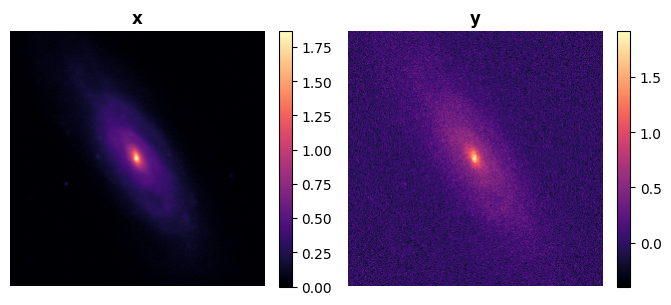

In [2]:
from matplotlib.colors import LogNorm
# Simulating an observation
sigma_y = 1e-1
y = x + sigma_y * torch.randn_like(x)


fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
im = ax.imshow(x.cpu().squeeze(), cmap = "magma")
plt.colorbar(im, fraction = 0.0455)
ax.axis("off")
ax.set_title(r"$\mathbf{x}$")

ax = axs[1]
im = ax.imshow(y.cpu().squeeze(), cmap = "magma")
plt.colorbar(im, fraction = 0.0455)
ax.axis("off")
ax.set_title(r"$\mathbf{y}$")

Our objective is now to infer plausible $\mathbf{x}$ given our observation. In a Bayesian view, performing this statistical inversion boils down to sampling from the posterior distribution, defined by 
$$
p(\mathbf{x} \mid \mathbf{y}) \propto p(\mathbf{x}) p(\mathbf{y}\mid \mathbf{x}) \, .
$$
Making this inference can be particularly challenging in high-dimensional spaces, especially due to the difficulty of encoding complex prior distributions. We can however use the framework of score models to encode priors and to perform this inference efficiently.

## Score-Based models
A score-based model learns the score of a probability distribution, defined as $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ over different noise scales. This learnt score can then be used to sample from the probability distribution $p(\mathbf{x})$. In our case, $p(\mathbf{x})$ is a probability distribution over galaxy images. The score at any temperature $t$ can be written as 
$$
\mathbf{s}_{\theta}(\mathbf{x}_t,t) \approx \nabla_{\mathbf{x}_t}\log p(\mathbf{x}_t) \qquad \mathbf{x}_t = \mu(t)\mathbf{x}_0 + \sigma(t)\mathbf{z}
$$
where $\mathbf{z}\sim \mathcal{N}(0, 1)$ is a random Gaussian variable, $\mu(t)$ and $\sigma(t)$ both depends on the type of score model used (specifically the stochastic differential equation used for the training of the neural network). I will not go into too much details concerning the SDEs (I recommend to check [Yang Song's work](https://arxiv.org/abs/2011.13456) if you are interested), but the most important thing is that we can sample any probability distribution by knowing its score, using numerical integration methods. Also, in a Bayesian view, a score model allows one to encode a prior. 


## Bayesian inference with score-based models
We now want to perform Bayesian inference with SBMs, using the SDE formalism. Again, we only need the score of the probability distribution of interest to be able to sample it. Therefore, let's write the score of the posterior distribution, and make it compatible with the SDE formalism
$$
\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t\mid \mathbf{y}) = \overbrace{\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)}^{\approx \mathbf{s}_{\theta}(\mathbf{x}_t,t)} + \nabla_{\mathbf{x}_t} \log p(\mathbf{y}\mid \mathbf{x}_t) \, .
$$

The prior's score can be learnt with an SBM, but the likelihood's score is intractable. If the noise model is a simple Gaussian, we can employ the *Convolved likelihood approximation* 
$$
p(\mathbf{y}\mid \mathbf{x}_t) =\mathcal{N}(\mu(t)\mathbf{y}\mid \mathbf{x}_t, \sigma_{y}^2\mathbb{I}_{n\times n} + \sigma^2(t)AA^{T}) \, .
$$

We now have all the elements needed to perform the inference. For this toy problem, we note that $AA^T=\mathbb{I}_{n\times n}$.

In [3]:
import sys
sys.path.append("../src")
from inference.posterior_sampling import euler_sampler
from torch.func import vmap, grad

# Identity forward model
def model(x): 
    return x

def mu(t, score_model): 
    return score_model.sde.marginal_prob_scalars(t)[0]

def sigma(t, score_model):
    return score_model.sde.sigma(t)

# Log probability of the convolved likelihood (if instrumental noise is Gaussian)
def log_likelihood(t, x, y = y, sigma_y = sigma_y, score_model = score_model, forward_model = model, model_parameters = None): 
    var = sigma(t, score_model) ** 2 + mu(t, score_model) ** 2 * sigma_y ** 2
    residuals = (y - forward_model(x))
    return -0.5 * torch.sum(residuals ** 2 / var)

# Score of the convolved likelihood
def score_likelihood(t, x, y = y, sigma_y = sigma_y, score_model = score_model, forward_model = model, model_parameters = None):
    return vmap(grad(lambda x, t: log_likelihood(t, x, y, sigma_y, score_model, forward_model, model_parameters)))(x, t)

In [4]:
# Running this is much faster on GPU ! 
samples = euler_sampler(
            y = y,
            sigma_y = sigma_y, 
            forward_model = model, 
            score_model = score_model,
            score_likelihood =  score_likelihood, 
            model_parameters = None,
            num_samples = 1, 
            num_steps = 1000,  # you can increase this to integrate with more precision. 
            img_size = (256, 256)
        )

  0%|          | 0/999 [00:00<?, ?it/s]

t = 0.00 | scale ~ 1.25e-01 | sigma(t) = 1.03e-04 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [03:47<00:00,  4.39it/s]


We can finally analyze how good is our posterior sample by computing the reduced chi-squared $\chi^2_{\nu}$. Note that having a good $\chi^2_{\nu}$ does not necessarily imply that the posterior distribution sampled with our approach is calibrated. Analyzing the posterior calibration involves doing a coverage test (we talk about this in more details in the IRIS paper). 

Text(0.1, 0.8, '$\\chi^2_{\\nu}=0.99$')

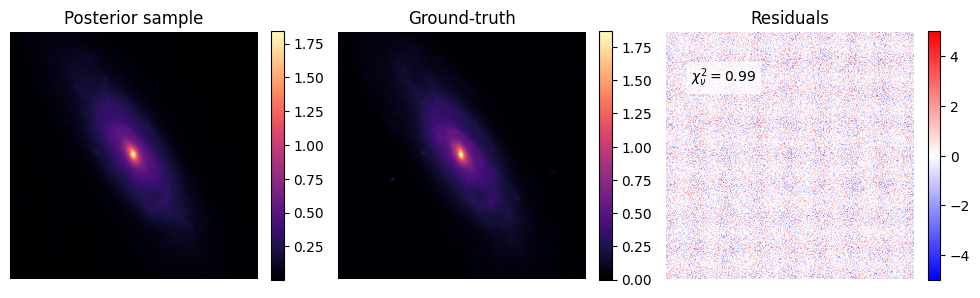

In [5]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))

ax = axs[0]
im = ax.imshow(samples.cpu().squeeze(), cmap = "magma")
plt.colorbar(im, fraction = 0.0455)
ax.axis("off")
ax.set_title("Posterior sample")

ax = axs[1]
im = ax.imshow(x.cpu().squeeze(), cmap = "magma")
plt.colorbar(im, fraction = 0.0455)
ax.axis("off")
ax.set_title("Ground-truth")

residuals = (y - samples)/sigma_y
nu = len(y.flatten())
reduced_chi2 = torch.sum(residuals ** 2) / nu
ax = axs[2]
im = ax.imshow(residuals.cpu().squeeze(), cmap = "bwr", vmin = -5, vmax = 5)
plt.colorbar(im, fraction = 0.0455)
ax.axis("off")
ax.set_title("Residuals")
ax.annotate(r"$\chi^2_{\nu}=%.2f$"%reduced_chi2, 
            xy = (0.1, 0.8),
            xycoords = "axes fraction", 
            bbox=dict(boxstyle="square", edgecolor='white', facecolor='white', alpha=0.7))